In [1]:
from pickle import FALSE
from socket import IPPROTO_UDP
import torch
import cv2
import numpy as np
from PIL import Image, ImageOps
from  matplotlib import pyplot as plt
import argparse
import yaml
import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utils_mllm import get_reflected_text_from_img, get_mask, fuse_mask, DotDict, printd, mkdir
import os
from diffusers import StableDiffusionInpaintPipeline

## Configs

In [2]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

parser = argparse.ArgumentParser(add_help=False)
parser.add_argument('--config', default='configs/CHAMELEON.yaml')
parser.add_argument('--visualization', action='store_true')
args_list = [
    '--config', 'config/CHAMELEON.yaml',
    '--visualization'
]

device = "cuda" if torch.cuda.is_available() else "cpu"
args = parser.parse_args(args_list)
with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
data_args = config['test_dataset']
model_args = DotDict(config)
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

/data/home/acw652/GenSAM-main/GenSAM_LLaVA/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Data

In [3]:
dataset = datasets.make(data_args['dataset'])
dataset = datasets.make(data_args['wrapper'], args={'dataset': dataset})
loader = DataLoader(dataset, batch_size=data_args['batch_size'],
                    num_workers=8)
paths_img = dataset.dataset.paths_img
data_len = len(paths_img)
printd(f"dataset size:\t {len(paths_img)}")

## save dir
config_name = args.config.split("/")[-1][:-5]
save_path_dir = f'output_img/{config_name}/'
mkdir(save_path_dir)

2024-09-07 14:57:34	 dataset size:	 76


## Load pretrained model

In [4]:
# CLIP surgery, SAM
from segment_anything import sam_model_registry, SamPredictor
from clip.clip_surgery_model import CLIPSurgery
import clip
sam = sam_model_registry[model_args.sam_model_type](checkpoint=model_args.sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
clip_params={ 'attn_qkv_strategy':model_args.clip_attn_qkv_strategy}
clip_model, _ = clip.load(model_args.clip_model, device=device, params=clip_params)
clip_model_ori, _ = clip.load(model_args.clip_model_ori, device=device, params=clip_params)
clip_model.eval()
clip_model_ori.eval()

# MLLM
llm_dict=None
if model_args.llm=='LLaVA':
    from llava.model.builder import load_pretrained_model
    from llava.utils import disable_torch_init
    from llava.mm_utils import get_model_name_from_path, KeywordsStoppingCriteria
    disable_torch_init()
    print(f'llava pretrained model: {model_args.model_path}')
    model_path = os.path.expanduser(model_args.model_path)
    model_args.model_name = get_model_name_from_path(model_path)
    tokenizer, model, image_processor, context_len = load_pretrained_model(
        model_path,
        model_args.model_base,
        model_args.model_name)
    if 'llama-2' in model_args.model_name.lower(): # from clip.py
        conv_mode = "llava_llama_2"
    elif "v1" in model_args.model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_args.model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"
    model_args.conv_mode = conv_mode
    llm_dict = {
        'model': model,
        'vis_processors':  image_processor,
        'tokenizer': tokenizer,
        'conv_mode': model_args.conv_mode,
        'temperature': model_args.temperature,
        'w_caption': model_args.LLaVA_w_caption,
    }
elif model_args.llm=='Mix':
    None
else:
    exit(f'unknow LLM: {model_args.llm}')

llava pretrained model: liuhaotian/llava-v1.5-13b


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Metrics

In [5]:
import utils
metric_fn = utils.calc_cod
metric1, metric2, metric3, metric4 = 'sm', 'em', 'wfm', 'mae'

val_metric1 = utils.Averager()
val_metric2 = utils.Averager()
val_metric3 = utils.Averager()
val_metric4 = utils.Averager()
recursive_times_l = []
text_similarity = []
miou_similarity = []
miou_after_similarity = []

## Run model

2024-09-07 14:59:04	 Start inference...


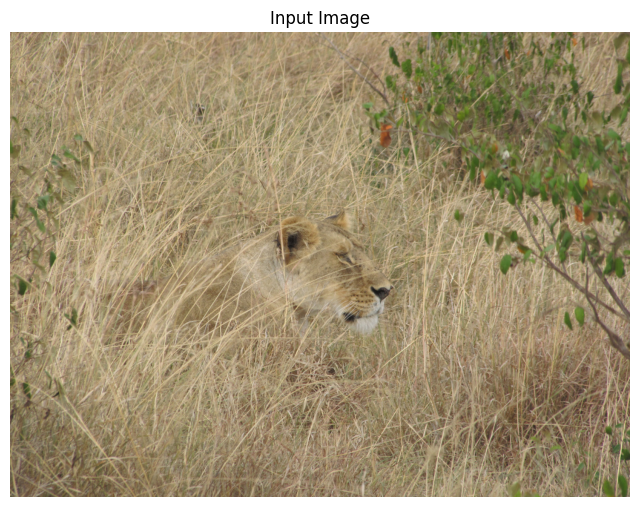

-------- interation 0 --------
A lion is camouflaged in the tall grass.
Lion
Grass
[0.0, 0.32, 0.76, 0.68]
A lion is camouflaged in the tall grass.
Lion
Grass
[0.37, 0.35, 1.0, 0.75]
A lion is camouflaged in the tall grass, looking at the camera.
Lion
Grass
[0.0, 0.27, 0.24, 0.71]
A lion is laying down in the tall grass, blending in with its surroundings.
Lion
Grass
[0.27, 0.74, 0.76, 0.99]
A lion is camouflaged in the tall grass, making it difficult to see.
Lion
Grass
[0.0, 0.0, 0.99, 0.18]


  0%|          | 0/50 [00:00<?, ?it/s]

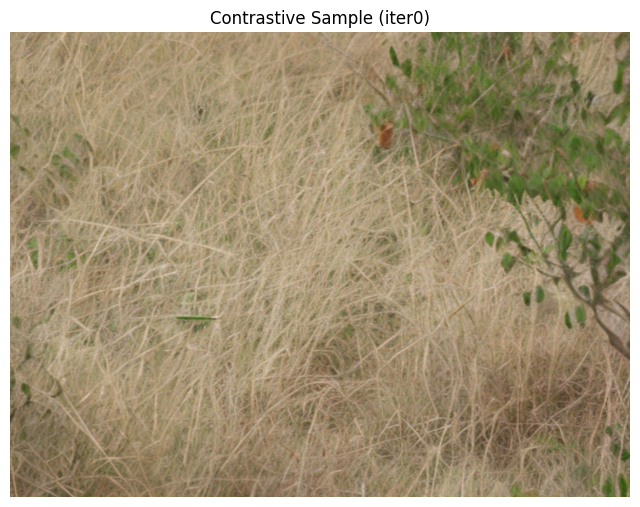

/data/home/acw652/GenSAM-main/GenSAM_LLaVA/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


True -8314572967248444522
[0.09, 0.35, 0.72, 0.67]
instance-specific bounding box [[0.0, 0.32, 0.76, 0.68], [0.18, 0.35, 0.5, 0.75], [0.5, 0.27, 0.62, 0.71], [0.27, 0.37, 0.76, 0.49], [0.0, 0.5, 0.99, 0.59], [0.09, 0.35, 0.72, 0.67]]
True -8314572967248444522
Lion
True -8314572967248444522
[0.0, 0.32, 0.76, 0.68]
instance-specific text prompt [['Lion']]


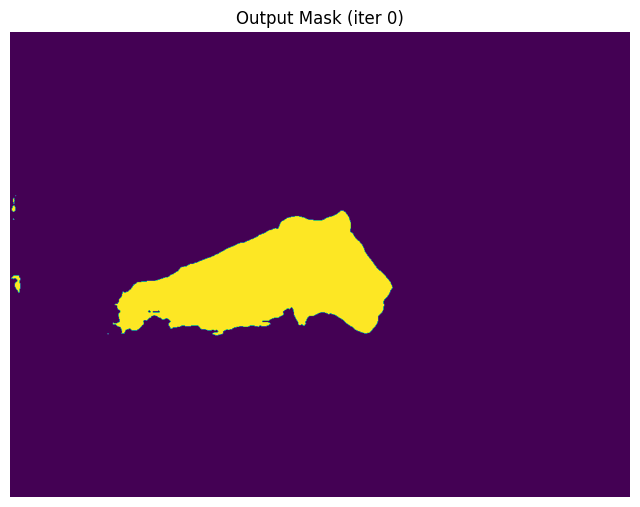

-------- interation 1 --------


  0%|          | 0/50 [00:00<?, ?it/s]

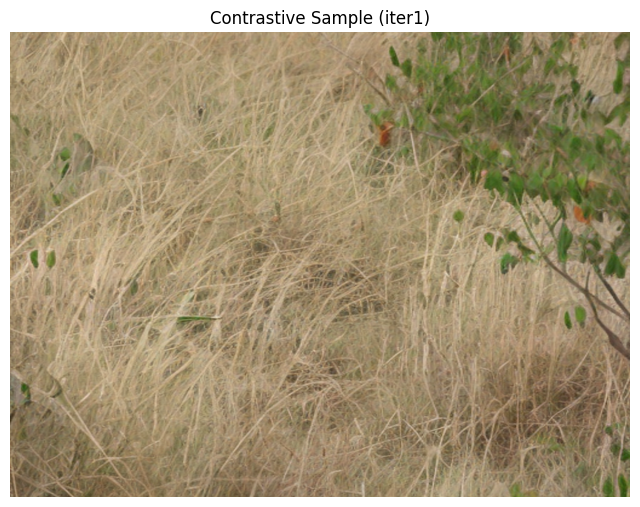

True -8314572967248444522
A lion camouflaged in tall brown grass is laying down.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0.0, 0.32, 0.74, 0.68]
True -8314572967248444522
A lion camouflaged in tall brown grass is laying down.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 1.0, 0]
True -8314572967248444522
A camouflaged lion is partially hidden behind tall brown grass and bushes.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A camouflaged lion is laying down in tall, dry grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0.7, 0.72, 1.0]
True -8314572967248444522
A lion camouflaged in tall brown grass is looking forward.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0.0, 0.0, 0.92, 0.24]
True -8314572967248444522
[0.09,

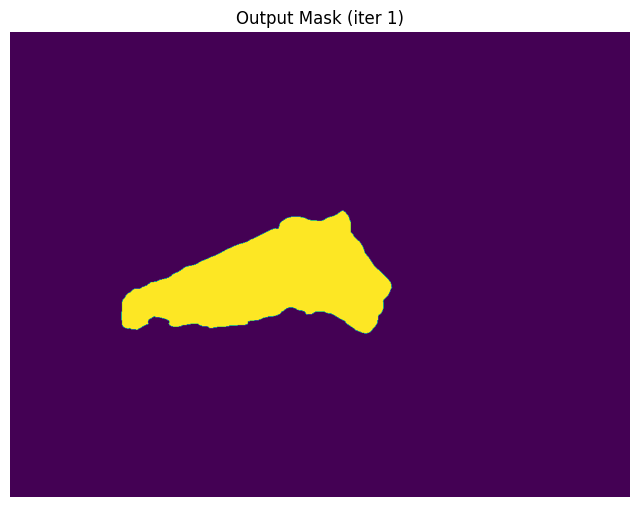

-------- interation 2 --------


  0%|          | 0/50 [00:00<?, ?it/s]

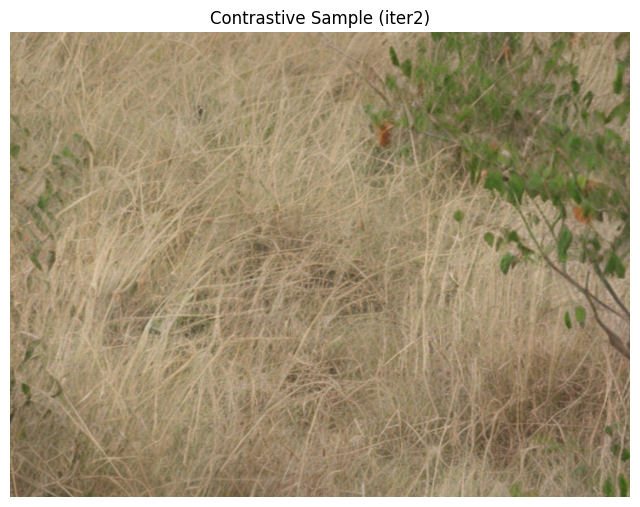

True -8314572967248444522
A camouflaged lion is laying in tall dry grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflages itself in tall brown grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflaged in tall brown grass and bushes.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflaged in tall brown grass sleeps in the field.
True -8314572967248444522
Lion
True -8314572967248444522
Field
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflaged in tall brown grass is looking forward.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
[0.09, 0.34, 0.71, 0.67]
instance-specific bounding box [[0.09, 0.34,

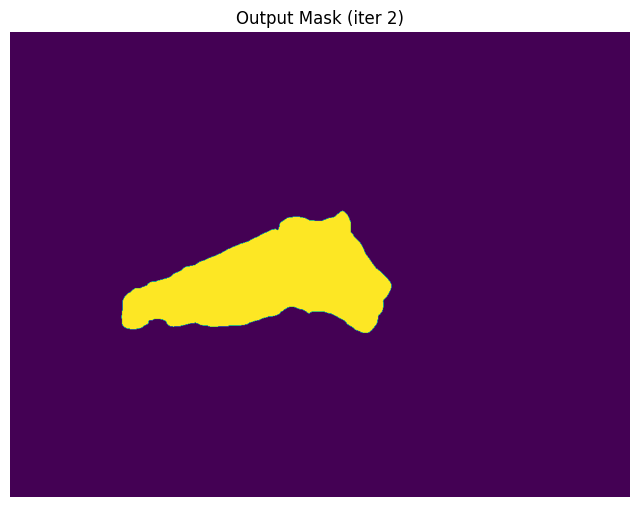

-------- interation 3 --------


  0%|          | 0/50 [00:00<?, ?it/s]

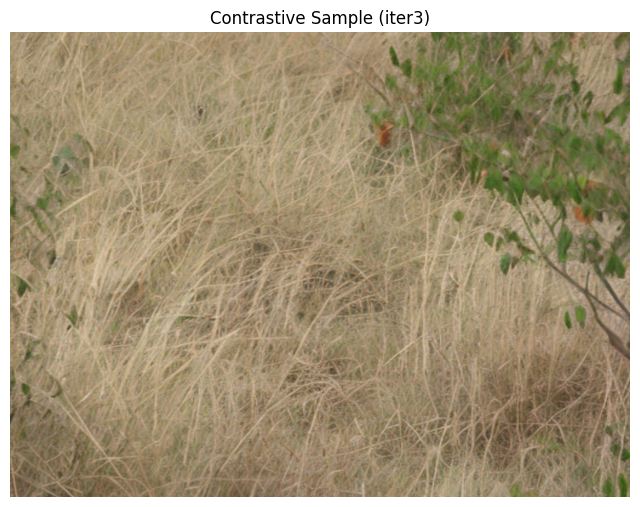

True -8314572967248444522
A camouflaged lion is laying in tall, dry grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflages itself in tall brown grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A camouflaged lion is partially hidden behind tall brown grass and some green leaves.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A camouflaged lion is laying in tall dry grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
A lion camouflages itself in tall brown grass.
True -8314572967248444522
Lion
True -8314572967248444522
Grass
True -8314572967248444522
[0, 0, 0, 0]
True -8314572967248444522
[0.09, 0.35, 0.74, 0.67]
instance-specific bounding box [

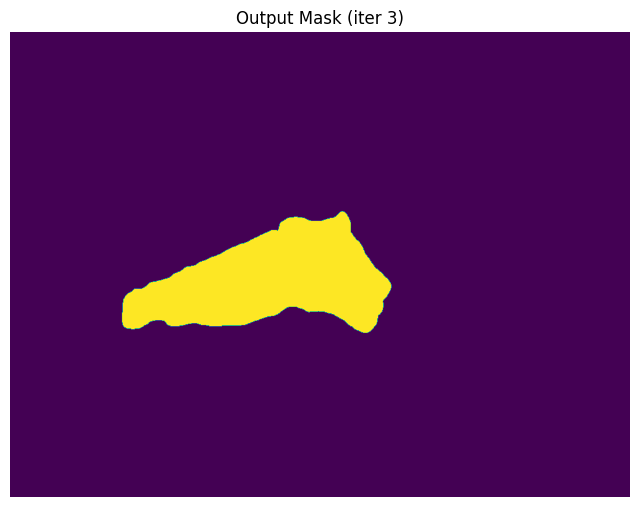

In [6]:
printd('Start inference...')
from utils import show
    
dataloader_iter = iter(loader)
pairs = next(dataloader_iter)
img_path = paths_img[0]
s_i = 0

pil_img = Image.open(img_path).convert("RGB")
show(pil_img, "Input Image")
mask_last = None
print(f'-------- interation 0 --------')
(text, text_bg, similarity_text, bbox, prediction) = get_reflected_text_from_img(
    pil_img,
    clip_model_ori,
    None,
    img_path,
    mask_last,
    None,
    sd_pipe,
    model_args.prompt_q,
    0,
    llm_dict,
    model_args.use_gene_prompt,
    model_args.clip_use_bg_text,
    model_args
)

(mask_l, mask_logit_origin_l, num_l, vis_dict, text_list, prediction_list) = get_mask(
    pil_img,
    text,
    bbox,
    sam_predictor,
    sd_pipe,
    clip_model,
    clip_model_ori,
    img_path,
    model_args,
    device,
    llm_dict=llm_dict,
    text_bg=text_bg,
    is_visualization=True
)
recursive_times = len(mask_l)
predict_list = []
predict_list = [prediction] + prediction_list
vis_mask_acc, vis_mask_logit_acc = fuse_mask(
    mask_logit_origin_l,
    sam_predictor.model.mask_threshold,
    predict_list
)  # fuse masks from different iterations

## Metric

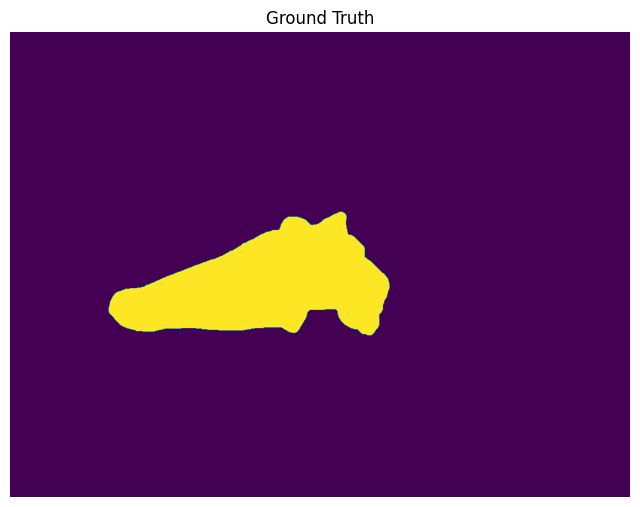

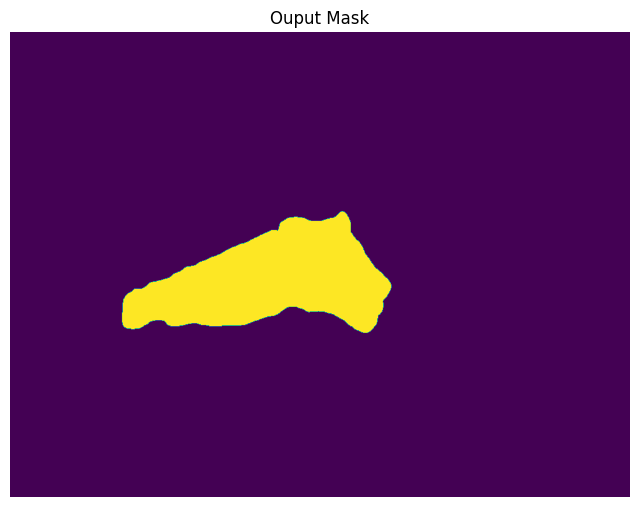

2024-09-07 15:01:54	 End inference...

closet to fuse (formated):
            0.009	            0.957	            0.987	            0.952	
average recursive times:  nan


/data/home/acw652/GenSAM-main/GenSAM_LLaVA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/home/acw652/GenSAM-main/GenSAM_LLaVA/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
path_gt = dataset.dataset.paths_gt[0]
pil_gt = Image.open(path_gt).convert("L")
show(pil_gt, "Ground Truth")

tensor_gt = pairs['gt']
tensor_gt[tensor_gt != 0] = 1.0
inp_size = 1024
mask_transform = transforms.Compose([
                transforms.Resize((inp_size, inp_size), interpolation=Image.NEAREST),
                transforms.ToTensor(),
            ])

# get metric of mask closest to fused mask
mask_delta_l = [np.sum((mask_i - vis_mask_acc)**2) for mask_i in mask_l]  # distance of each mask to fused one
idxMaskSim = np.argmin(mask_delta_l)
vis_tensor = Image.fromarray(mask_l[idxMaskSim].astype('uint8'))
show(vis_tensor, "Ouput Mask")

vis_tensor = mask_transform(vis_tensor)[0].view(1, 1, inp_size, inp_size)
result1, result2, result3, result4 = metric_fn(vis_tensor, tensor_gt)
val_metric1.add(result1, tensor_gt.shape[0])
val_metric2.add(result2, tensor_gt.shape[0])
val_metric3.add(result3, tensor_gt.shape[0])
val_metric4.add(result4, tensor_gt.shape[0])

printd('End inference...')
print(f'\ncloset to fuse (formated):\n\
            {round(val_metric4.item(),4):.3f}\t\
            {round(val_metric3.item(),4):.3f}\t\
            {round(val_metric2.item(),4):.3f}\t\
            {round(val_metric1.item(),4):.3f}\t')
print('average recursive times: ', np.mean(recursive_times_l ))